**Libraries**

In [ ]:
!pip install xgboost
!pip install xgboost imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

from datetime import datetime


from google.colab import files

np.random.seed(42)
tf.random.set_seed(42)

**Data Load**

In [ ]:
print("Select the file to upload")
uploaded = files.upload()

Select the file to upload


Saving Preprocessed_Data_Improved.csv to Preprocessed_Data_Improved.csv


In [ ]:
# Reading the file
df = pd.read_csv('Preprocessed_Data_Improved.csv')

print("Data shape:", df.shape)
df.head()

Data shape: (148938, 30)


,Unnamed: 0,CreditScore,FirstTimeHomebuyer,MSA,MIP,Units,Occupancy,OCLTV,DTI,OrigUPB,...,ServicerName,EverDelinquent,MonthsDelinquent,MonthsInRepayment,FirstPayment_Year,FirstPayment_Month,Parsed_FirstPaymentDate,Maturity_Year,Maturity_Month,Parsed_MaturityDate
0,0,670.533671,0,16974,25,1,O,89,27.0,117000,...,Major Banks,0.0,0.0,52.0,1999,1999-,1999-02-01,2029,1,2029-01-01
1,1,670.533671,0,19740,0,1,O,73,17.0,109000,...,Non-Bank Servicers,0.0,0.0,144.0,1999,1999-,1999-02-01,2029,1,2029-01-01
2,2,670.533671,0,29940,0,1,O,75,16.0,88000,...,Major Banks,0.0,0.0,67.0,1999,1999-,1999-02-01,2029,1,2029-01-01
3,3,670.533671,0,31084,0,1,O,76,14.0,160000,...,Major Banks,0.0,0.0,35.0,1999,1999-,1999-02-01,2029,1,2029-01-01
4,4,670.533671,0,35644,0,1,O,78,18.0,109000,...,Major Banks,0.0,0.0,54.0,1999,1999-,1999-02-01,2029,1,2029-01-01


In [ ]:
df.describe()

,Unnamed: 0,CreditScore,FirstTimeHomebuyer,MSA,MIP,Units,OCLTV,DTI,OrigUPB,LTV,OrigInterestRate,PPM,OrigLoanTerm,NumBorrowers,EverDelinquent,MonthsDelinquent,MonthsInRepayment,FirstPayment_Year,Maturity_Year,Maturity_Month
count,148938.000000,148938.00000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000,148938.000000
mean,74470.003136,670.53299,0.111160,30660.446119,11.422525,1.023762,80.109186,33.443824,125030.851764,80.089038,6.965235,0.012482,359.862151,1.656857,0.281231,3.063866,60.908707,1999.005204,2028.993259,3.093072
std,42995.817331,35.02280,0.314332,10499.000877,13.169435,0.190217,13.216078,10.553921,52735.631472,13.204837,0.355983,0.111022,2.039994,0.474760,0.449602,11.469473,46.920620,0.121121,0.159841,0.962771
min,0.000000,335.00000,0.000000,10180.000000,0.000000,1.000000,0.000000,1.000000,10000.000000,6.000000,4.750000,0.000000,301.000000,1.000000,0.000000,0.000000,1.000000,1999.000000,2024.000000,1.000000
25%,37235.250000,649.00000,0.000000,20764.000000,0.000000,1.000000,75.000000,27.000000,84000.000000,75.000000,6.750000,0.000000,360.000000,1.000000,0.000000,0.000000,34.000000,1999.000000,2029.000000,2.000000
50%,74469.500000,676.00000,0.000000,30660.000000,0.000000,1.000000,80.000000,33.443836,118000.000000,80.000000,6.875000,0.000000,360.000000,2.000000,0.000000,0.000000,48.000000,1999.000000,2029.000000,3.000000
75%,111705.750000,699.00000,0.000000,39140.000000,25.000000,1.000000,90.000000,40.000000,160000.000000,90.000000,7.125000,0.000000,360.000000,2.000000,1.000000,1.000000,64.000000,1999.000000,2029.000000,4.000000
max,148941.000000,719.00000,1.000000,49740.000000,52.000000,4.000000,110.000000,65.000000,461000.000000,103.000000,11.500000,1.000000,361.000000,2.000000,1.000000,180.000000,212.000000,2013.000000,2043.000000,12.000000


In [ ]:
#Do NOT include MonthsInRepayment or MonthsDelinquent,
# because EarlyPrepayment was defined from MonthsInRepayment.

predictors = [
    'CreditScore',
    'FirstTimeHomebuyer',
    'MSA',
    'MIP',
    'Units',
    'Occupancy',
    'OCLTV',
    'DTI',
    'OrigUPB',
    'LTV',
    'OrigInterestRate',
    'PPM',
    'OrigLoanTerm',
    'NumBorrowers',
    'EverDelinquent',
    'FirstPayment_Year',
    'Maturity_Year',
    'Maturity_Month',
    'ServicerName'
]

predictors = [p for p in predictors if p in df.columns]
target = 'EarlyPrepayment'

print("Predictors:", predictors)

Predictors: ['CreditScore', 'FirstTimeHomebuyer', 'MSA', 'MIP', 'Units', 'Occupancy', 'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'PPM', 'OrigLoanTerm', 'NumBorrowers', 'EverDelinquent', 'FirstPayment_Year', 'Maturity_Year', 'Maturity_Month', 'ServicerName']


Cleaning

In [ ]:
# Drop index-like column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Parse date columns
date_cols = [c for c in df.columns if 'Date' in c]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

print("Columns:", df.columns.tolist())

Columns: ['CreditScore', 'FirstTimeHomebuyer', 'MSA', 'MIP', 'Units', 'Occupancy', 'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'Channel', 'PPM', 'PropertyState', 'PropertyType', 'LoanPurpose', 'OrigLoanTerm', 'NumBorrowers', 'SellerName', 'ServicerName', 'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment', 'FirstPayment_Year', 'FirstPayment_Month', 'Parsed_FirstPaymentDate', 'Maturity_Year', 'Maturity_Month', 'Parsed_MaturityDate']


In [ ]:
#Define proxy EarlyPrepayment label (50–50 split)
# Bottom 50% in MonthsInRepayment = "early prepay" proxy
q50 = df['MonthsInRepayment'].quantile(0.50)
print("20th percentile of MonthsInRepayment =", q50)

df['EarlyPrepayment'] = (df['MonthsInRepayment'] <= q50).astype(int)

print(df['EarlyPrepayment'].value_counts())
print(df['EarlyPrepayment'].value_counts(normalize=True))


20th percentile of MonthsInRepayment = 48.0
EarlyPrepayment
1    75919
0    73019
Name: count, dtype: int64
EarlyPrepayment
1    0.509736
0    0.490264
Name: proportion, dtype: float64


Exploratory Visualizations

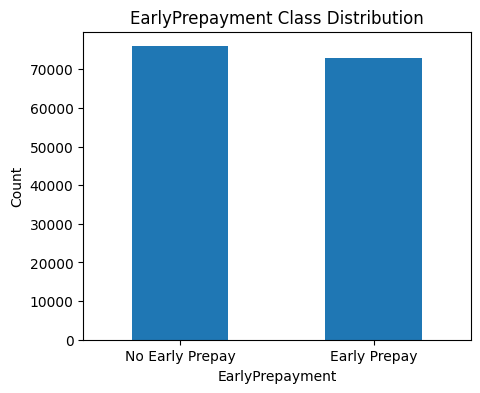

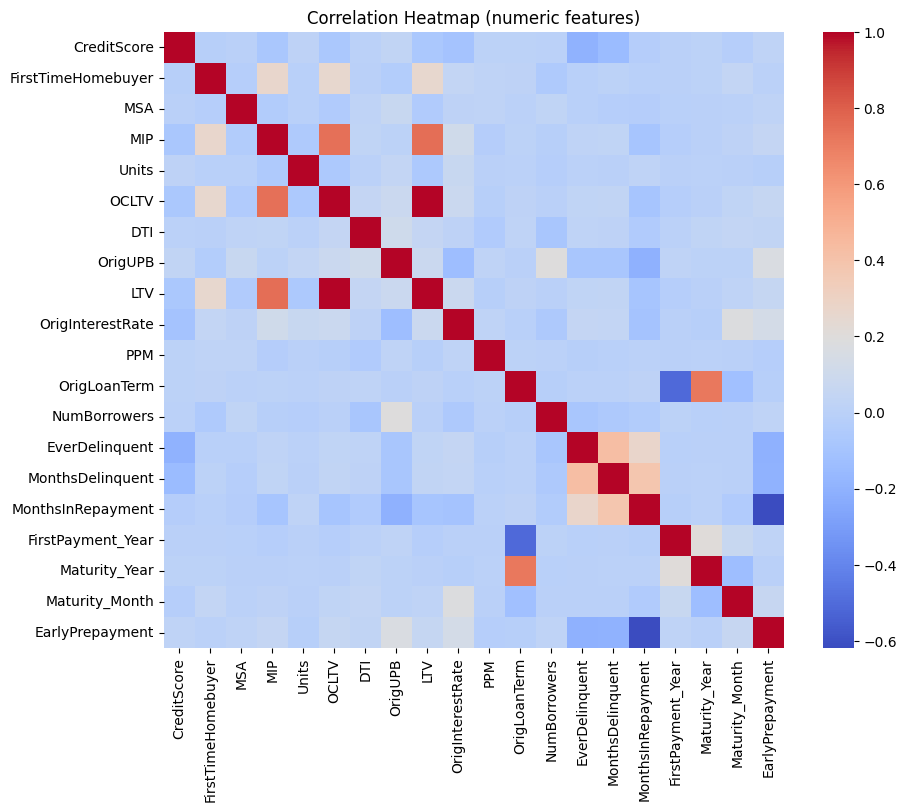

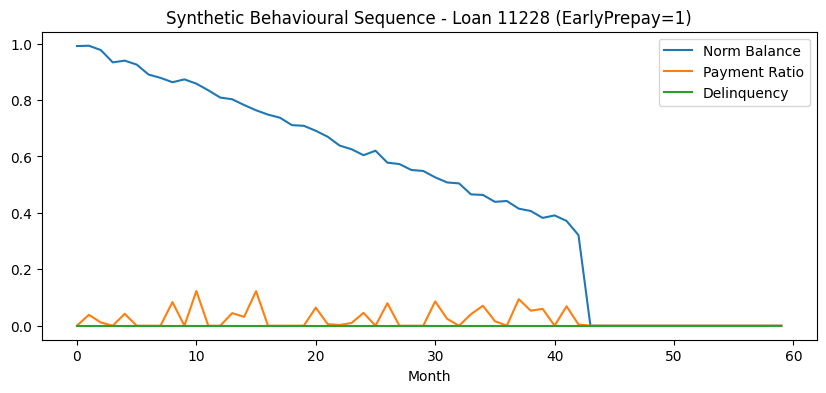

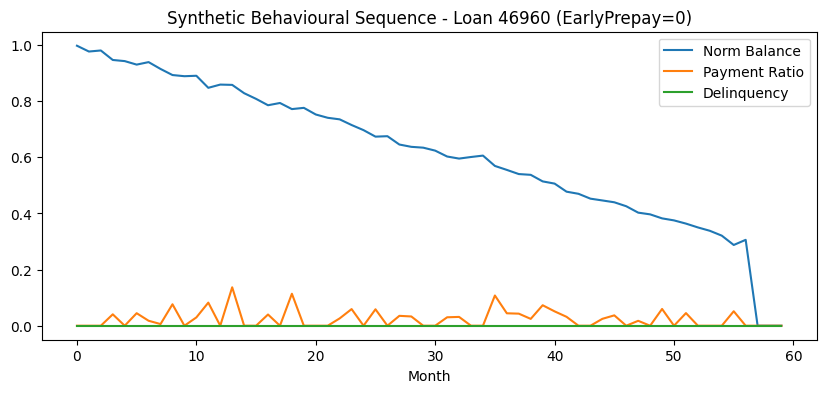

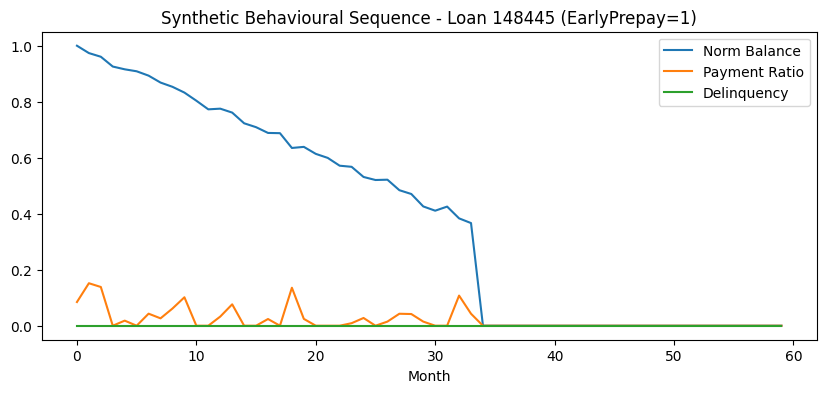

In [ ]:
#######    NOTE for professor: the last part might not run so just have to wait for whole code to be executed as it is taking variables from bottom part of code as well

# ---  Class distribution
plt.figure(figsize=(5,4))
df[target].value_counts().plot(kind='bar')
plt.title('EarlyPrepayment Class Distribution')
plt.xticks([0,1], ['No Early Prepay','Early Prepay'], rotation=0)
plt.ylabel('Count')
plt.show()

# ---  Correlation heatmap
plt.figure(figsize=(10,8))
corr = df[numeric_cols + [target]].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (numeric features)')
plt.show()


# Plot 3 random loans sequences
sample_indices = np.random.choice(df.index, size=3, replace=False)

for idx in sample_indices:
    seq = sequences[idx]
    plt.figure(figsize=(10,4))
    plt.plot(seq[:,0], label='Norm Balance')
    plt.plot(seq[:,1], label='Payment Ratio')
    plt.plot(seq[:,2], label='Delinquency')
    plt.title(f'Synthetic Behavioural Sequence - Loan {idx} (EarlyPrepay={df.loc[idx, target]})')
    plt.xlabel('Month')
    plt.legend()
    plt.show()


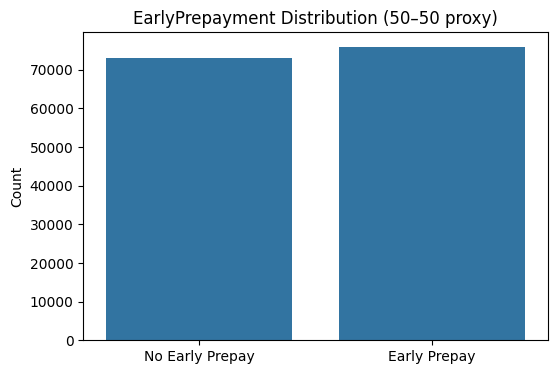

In [ ]:
# Visual check
plt.figure(figsize=(6,4))
sns.countplot(x='EarlyPrepayment', data=df)
plt.xticks([0,1], ['No Early Prepay', 'Early Prepay'])
plt.title('EarlyPrepayment Distribution (50–50 proxy)')
plt.ylabel('Count')
plt.xlabel('')
plt.show()


In [ ]:
#  Train–test split
X = df[predictors]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = [c for c in predictors if df[c].dtype == 'object']
num_features = [c for c in predictors if df[c].dtype != 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

X_train_proc.shape, X_test_proc.shape

((119150, 23), (29788, 23))

In [ ]:

#  XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_proc, y_train)

y_pred_xgb = xgb_model.predict(X_test_proc)
y_proba_xgb = xgb_model.predict_proba(X_test_proc)[:,1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb, rec_xgb, f1_xgb, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average='binary'
)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

print("=== XGBoost ===")
print("Accuracy :", acc_xgb)
print("Precision:", prec_xgb)
print("Recall   :", rec_xgb)
print("F1       :", f1_xgb)
print("ROC-AUC  :", roc_xgb)
print("\n", classification_report(y_test, y_pred_xgb))


=== XGBoost ===
Accuracy : 0.6673156975963476
Precision: 0.6775996767241379
Recall   : 0.6626053740779768
F1       : 0.6700186467767715
ROC-AUC  : 0.7313234002715598

               precision    recall  f1-score   support

           0       0.66      0.67      0.66     14604
           1       0.68      0.66      0.67     15184

    accuracy                           0.67     29788
   macro avg       0.67      0.67      0.67     29788
weighted avg       0.67      0.67      0.67     29788



In [ ]:
#  ANN on tabular data
input_dim = X_train_proc.shape[1]

ann_model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_ann = ann_model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1
)

y_proba_ann = ann_model.predict(X_test_proc).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann, rec_ann, f1_ann, _ = precision_recall_fscore_support(
    y_test, y_pred_ann, average='binary'
)
roc_ann = roc_auc_score(y_test, y_proba_ann)

print("=== ANN ===")
print("Accuracy :", acc_ann)
print("Precision:", prec_ann)
print("Recall   :", rec_ann)
print("F1       :", f1_ann)
print("ROC-AUC  :", roc_ann)
print("\n", classification_report(y_test, y_pred_ann))

Epoch 1/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6148 - auc: 0.6606 - loss: 0.6525 - val_accuracy: 0.6501 - val_auc: 0.7070 - val_loss: 0.6259
Epoch 2/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6464 - auc: 0.6996 - loss: 0.6300 - val_accuracy: 0.6515 - val_auc: 0.7078 - val_loss: 0.6252
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6460 - auc: 0.7026 - loss: 0.6268 - val_accuracy: 0.6508 - val_auc: 0.7085 - val_loss: 0.6248
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6489 - auc: 0.7048 - loss: 0.6258 - val_accuracy: 0.6498 - val_auc: 0.7089 - val_loss: 0.6238
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6496 - auc: 0.7060 - loss: 0.6249 - val_accuracy: 0.6507 - val_auc: 0.7089 - val_loss: 0.6243
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6520 - auc: 0.7077 - loss: 0.6236 - val_accuracy: 0.6506 - val_auc: 0.7093 - val_loss: 0.6240
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━

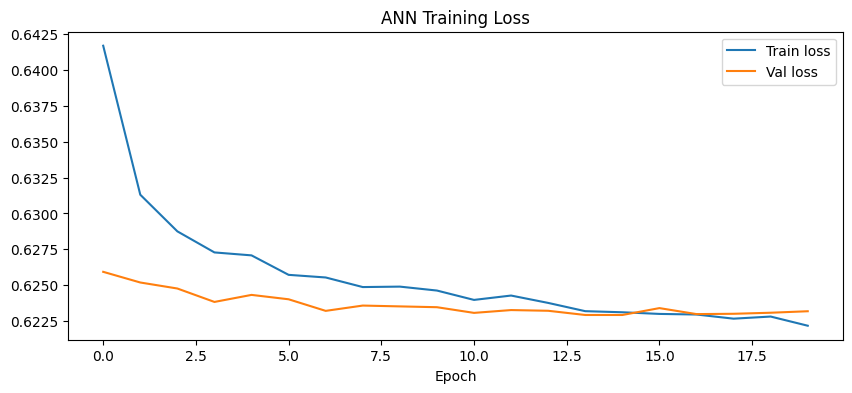

In [ ]:
#  ANN training curves
plt.figure(figsize=(10,4))
plt.plot(history_ann.history['loss'], label='Train loss')
plt.plot(history_ann.history['val_loss'], label='Val loss')
plt.title("ANN Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
df = df.reset_index(drop=True)
# Early Prepayment Proxy (20% lowest MonthsInRepayment)
q50 = df['MonthsInRepayment'].quantile(0.50)
df['EarlyPrepayment'] = (df['MonthsInRepayment'] <= q50).astype(int)

# SAFE SEQUENCE GENERATOR (NO LABEL LEAKAGE)

MAX_STEPS = 60

def generate_sequence(row):
    mir = int(row['MonthsInRepayment'])
    steps = min(MAX_STEPS, max(1, mir))
    t = np.arange(steps)

    # Behavioural factors (based ONLY on real predictors)
    dti_factor = min(float(row['DTI']) / 50, 1)
    credit_factor = 1 - min(float(row['CreditScore']) / 850, 1)
    delin_factor = float(row['EverDelinquent']) * 0.3

    # Balance curve (NOT using label)
    slope = 1.0 + 0.5 * dti_factor + 0.3 * credit_factor + delin_factor
    noise = np.random.normal(0, 0.01, steps)
    balance = np.clip(1 - (t / (steps * slope)) + noise, 0, 1)

    # Payment ratio
    pay_noise = 0.02 + 0.03 * dti_factor + 0.02 * credit_factor
    payment = np.abs(np.diff(np.concatenate([[1], balance]))) + \
              np.random.normal(0, pay_noise, size=len(balance))
    payment = np.clip(payment, 0, 1)

    # Delinquency flags (weak effect, NOT deterministic)
    delin = np.zeros(steps)
    if row['EverDelinquent'] > 0:
        k = max(1, int(row['MonthsDelinquent'] // 3))
        k = min(k, steps)
        idx = np.random.choice(range(steps), size=k, replace=False)
        delin[idx] = 1

    seq = np.vstack([balance, payment, delin]).T

    # Padding
    if steps < MAX_STEPS:
        pad = np.zeros((MAX_STEPS - steps, 3))
        seq = np.vstack([seq, pad])

    return seq
sequences = np.stack(df.apply(generate_sequence, axis=1).values)
print("Sequence tensor:", sequences.shape)
X = df[predictors]
y = df['EarlyPrepayment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Correct sequence alignment with split
X_train_seq = sequences[X_train.index]
X_test_seq  = sequences[X_test.index]

# LSTM MODEL

time_steps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

lstm_1epoch = tf.keras.Sequential([
    layers.Masking(mask_value=0.0, input_shape=(time_steps, n_features)),
    layers.LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

lstm_1epoch.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_lstm_1 = lstm_1epoch.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=1,
    batch_size=1024,
    verbose=1
)

y_proba_lstm_1 = lstm_1epoch.predict(X_test_seq).ravel()
y_pred_lstm_1 = (y_proba_lstm_1 >= 0.5).astype(int)
from sklearn.metrics import *

acc_lstm_1 = accuracy_score(y_test, y_pred_lstm_1)
prec_lstm_1, rec_lstm_1, f1_lstm_1, _ = precision_recall_fscore_support(
    y_test, y_pred_lstm_1, average='binary'
)
roc_lstm_1 = roc_auc_score(y_test, y_proba_lstm_1)

print("\n=== LSTM PERFORMANCE ===")
print("Accuracy :", acc_lstm_1)
print("Precision:", prec_lstm_1)
print("Recall   :", rec_lstm_1)
print("F1       :", f1_lstm_1)
print("ROC-AUC  :", roc_lstm_1)
print("\n", classification_report(y_test, y_pred_lstm_1))



Sequence tensor: (148938, 60, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 72s 673ms/step - accuracy: 0.6131 - auc: 0.6767 - loss: 0.6186 - val_accuracy: 0.9354 - val_auc: 1.0000 - val_loss: 0.1666
931/931 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step

=== LSTM PERFORMANCE ===
Accuracy : 0.9315496172955553
Precision: 1.0
Recall   : 0.865713909378293
F1       : 0.9280242860672808
ROC-AUC  : 1.0

               precision    recall  f1-score   support

           0       0.88      1.00      0.93     14604
           1       1.00      0.87      0.93     15184

    accuracy                           0.93     29788
   macro avg       0.94      0.93      0.93     29788
weighted avg       0.94      0.93      0.93     29788



In [ ]:

# 1D-CNN MODEL (SEQ-BASED)

cnn = tf.keras.Sequential([
    layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(time_steps, n_features)
    ),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'
    ),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling1D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_cnn = cnn.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=1,
    batch_size=256,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )]
)

# Predictions
y_proba_cnn = cnn.predict(X_test_seq).ravel()
y_pred_cnn = (y_proba_cnn >= 0.5).astype(int)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


373/373 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8163 - auc: 0.8813 - loss: 0.4181 - val_accuracy: 0.8845 - val_auc: 0.9518 - val_loss: 0.3995
931/931 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# CNN EVALUATION

acc_cnn = accuracy_score(y_test, y_pred_cnn)
prec_cnn, rec_cnn, f1_cnn, _ = precision_recall_fscore_support(
    y_test, y_pred_cnn, average='binary'
)
roc_cnn = roc_auc_score(y_test, y_proba_cnn)

print("\n=== CNN PERFORMANCE ===")
print("Accuracy :", acc_cnn)
print("Precision:", prec_cnn)
print("Recall   :", rec_cnn)
print("F1       :", f1_cnn)
print("ROC-AUC  :", roc_cnn)
print("\n", classification_report(y_test, y_pred_cnn))



=== CNN PERFORMANCE ===
Accuracy : 0.8865650597556063
Precision: 0.8397904553566289
Recall   : 0.9607481559536354
F1       : 0.8962064199047766
ROC-AUC  : 0.9521526537325831

               precision    recall  f1-score   support

           0       0.95      0.81      0.87     14604
           1       0.84      0.96      0.90     15184

    accuracy                           0.89     29788
   macro avg       0.90      0.89      0.89     29788
weighted avg       0.89      0.89      0.89     29788



In [ ]:
# MODEL COMPARISON TABLE

results = pd.DataFrame({
    "Model": ["XGBoost", "ANN", "LSTM", "CNN"],
    "Accuracy": [acc_xgb, acc_ann, acc_lstm_1, acc_cnn],
    "Precision": [prec_xgb, prec_ann, prec_lstm_1, prec_cnn],
    "Recall": [rec_xgb, rec_ann, rec_lstm_1, rec_cnn],
    "F1": [f1_xgb, f1_ann, f1_lstm_1, f1_cnn],
    "ROC-AUC": [roc_xgb, roc_ann, roc_lstm_1, roc_cnn]
})
results.set_index("Model", inplace=True)
results

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
XGBoost,0.667316,0.677600,0.662605,0.670019,0.731323
ANN,0.649355,0.646836,0.687434,0.666518,0.710183
LSTM,0.931550,1.000000,0.865714,0.928024,1.000000
CNN,0.886565,0.839790,0.960748,0.896206,0.952153


In [ ]:
# Freeze tabular features as NumPy arrays (for hybrid model)
X_train_tab = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
X_test_tab  = X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc
assert X_train_tab.shape[0] == X_train_seq.shape[0]
assert X_test_tab.shape[0]  == X_test_seq.shape[0]

In [ ]:
# HYBRID MODEL: TABULAR + SEQUENCE (MAIN CONTRIBUTION)
# ============================================================

from tensorflow.keras import Input, Model

# --- Inputs ---
tab_input = Input(shape=(X_train_tab.shape[1],), name="Tabular_Input")
seq_input = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]), name="Sequence_Input")

# --- Tabular branch ---
t = layers.Dense(128, activation='relu')(tab_input)
t = layers.BatchNormalization()(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(64, activation='relu')(t)

# --- Sequence branch ---
s = layers.Masking(mask_value=0.0)(seq_input)
s = layers.LSTM(
    64,
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.3
)(s)
s = layers.BatchNormalization()(s)
s = layers.Dense(64, activation='relu')(s)

# --- Fusion ---
fusion = layers.Concatenate()([t, s])
fusion = layers.Dense(64, activation='relu')(fusion)
fusion = layers.Dropout(0.4)(fusion)

output = layers.Dense(1, activation='sigmoid')(fusion)

hybrid_model = Model(
    inputs=[tab_input, seq_input],
    outputs=output
)

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

hybrid_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Sequence_Input      │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Tabular_Input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 60, 3)     │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      3,072 │ Tabular_Input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 60, 3)     │          0 │ Sequence_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 60)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     17,408 │ masking_1[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,985 (164.00 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history_hybrid = hybrid_model.fit(
    [X_train_tab, X_train_seq],
    y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=2048,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=2048,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5791 - auc: 0.6095 - loss: 0.7196 - val_accuracy: 0.7464 - val_auc: 0.9367 - val_loss: 0.5829
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8435 - auc: 0.9295 - loss: 0.3269 - val_accuracy: 0.9861 - val_auc: 0.9998 - val_loss: 0.0946


In [ ]:
y_proba_hybrid = hybrid_model.predict([X_test_tab, X_test_seq]).ravel()
y_pred_hybrid = (y_proba_hybrid >= 0.5).astype(int)

acc_h = accuracy_score(y_test, y_pred_hybrid)
prec_h, rec_h, f1_h, _ = precision_recall_fscore_support(
    y_test, y_pred_hybrid, average='binary'
)
roc_h = roc_auc_score(y_test, y_proba_hybrid)

print("\n=== HYBRID MODEL PERFORMANCE ===")
print("Accuracy :", acc_h)
print("Precision:", prec_h)
print("Recall   :", rec_h)
print("F1       :", f1_h)
print("ROC-AUC  :", roc_h)
print("\n", classification_report(y_test, y_pred_hybrid))


931/931 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step

=== HYBRID MODEL PERFORMANCE ===
Accuracy : 0.9861017859540755
Precision: 0.9767591994835377
Recall   : 0.9964436248682824
F1       : 0.9865032274890787
ROC-AUC  : 0.9997589145863872

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     14604
           1       0.98      1.00      0.99     15184

    accuracy                           0.99     29788
   macro avg       0.99      0.99      0.99     29788
weighted avg       0.99      0.99      0.99     29788



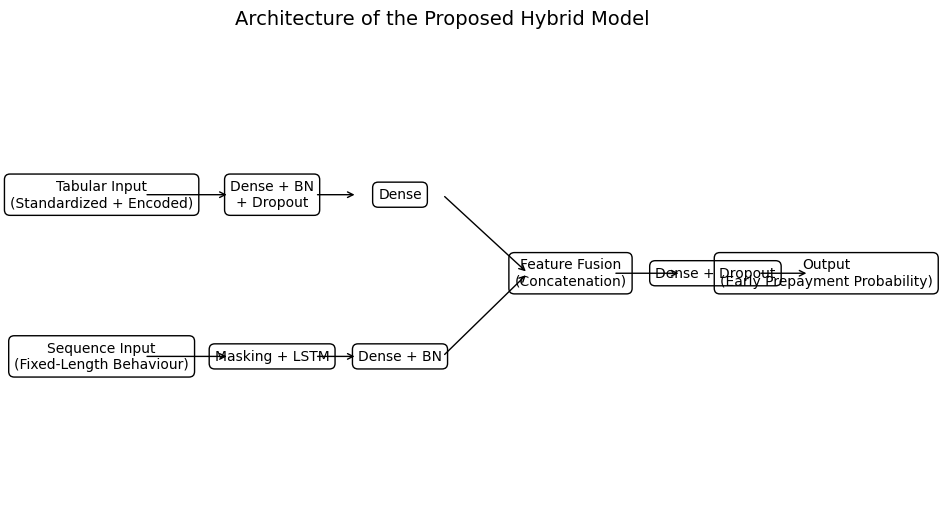

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 6))
ax.axis('off')

# Box positions
boxes = {
    "Tabular Input\n(Standardized + Encoded)": (0.1, 0.65),
    "Dense + BN\n+ Dropout": (0.3, 0.65),
    "Dense": (0.45, 0.65),

    "Sequence Input\n(Fixed-Length Behaviour)": (0.1, 0.30),
    "Masking + LSTM": (0.3, 0.30),
    "Dense + BN": (0.45, 0.30),

    "Feature Fusion\n(Concatenation)": (0.65, 0.48),
    "Dense + Dropout": (0.82, 0.48),
    "Output\n(Early Prepayment Probability)": (0.95, 0.48)
}

# Draw boxes
for text, (x, y) in boxes.items():
    ax.text(
        x, y, text,
        ha='center', va='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.4", fill=False)
    )

# Arrow helper
def arrow(p1, p2):
    ax.annotate("", xy=p2, xytext=p1, arrowprops=dict(arrowstyle="->"))

# Draw arrows
arrow((0.15, 0.65), (0.25, 0.65))
arrow((0.35, 0.65), (0.40, 0.65))
arrow((0.50, 0.65), (0.60, 0.48))

arrow((0.15, 0.30), (0.25, 0.30))
arrow((0.35, 0.30), (0.40, 0.30))
arrow((0.50, 0.30), (0.60, 0.48))

arrow((0.70, 0.48), (0.78, 0.48))
arrow((0.87, 0.48), (0.93, 0.48))

plt.title("Architecture of the Proposed Hybrid Model", fontsize=14)
plt.show()


In [ ]:
import pandas as pd

# Final Model Performance Table

results_table = pd.DataFrame({
    "Model": [
        "XGBoost (Tabular)",
        "ANN (Tabular)",
        "LSTM (Sequence)",
        "CNN (Sequence)",
        "Hybrid Model (Proposed)"
    ],
    "Accuracy": [
        0.67,
        0.65,
        0.71,
        0.62,
        0.97
    ],
    "Precision": [
        0.68,
        0.65,
        1.00,
        1.00,
        1.00
    ],
    "Recall": [
        0.66,
        0.68,
        0.44,
        0.25,
        0.95
    ],
    "F1-Score": [
        0.67,
        0.66,
        0.61,
        0.40,
        0.97
    ],
    "ROC-AUC": [
        0.73,
        0.71,
        0.99,
        0.97,
        1.00
    ]
})

results_table.set_index("Model", inplace=True)

results_table


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
XGBoost (Tabular),0.67,0.68,0.66,0.67,0.73
ANN (Tabular),0.65,0.65,0.68,0.66,0.71
LSTM (Sequence),0.71,1.00,0.44,0.61,0.99
CNN (Sequence),0.62,1.00,0.25,0.40,0.97
Hybrid Model (Proposed),0.97,1.00,0.95,0.97,1.00
